# Clustering

In [1]:
%load_ext autoreload
%autoreload 2
import os, inspect, sys
main_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory
RGCPD_func = os.path.join(main_dir, 'RGCPD')
cluster_func = os.path.join(main_dir, 'clustering')
if RGCPD_func not in sys.path:
    sys.path.append(RGCPD_func)
    sys.path.append(cluster_func)

In [2]:
%load_ext autoreload
%autoreload 2
import clustering_spatial as cl
from RGCPD import RGCPD
import plot_maps
rg = RGCPD()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Not able to load in Tigramite modules, to enable causal inference features, install Tigramite from https://github.com/jakobrunge/tigramite/
Not able to load in plotting modules, check installment of networkx
initializing with test data


In [3]:
rg.pp_precursors()

Loaded pre-processed data of sst_test



In [4]:
rg.list_precur_pp

[('sst_test',
  '/Users/semvijverberg/surfdrive/Scripts/RGCPD/RGCPD/../data/preprocessed/sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc')]



Plotting Corr maps sst, split 0, lag 0


Plotting Corr maps sst, split 0, lag 0


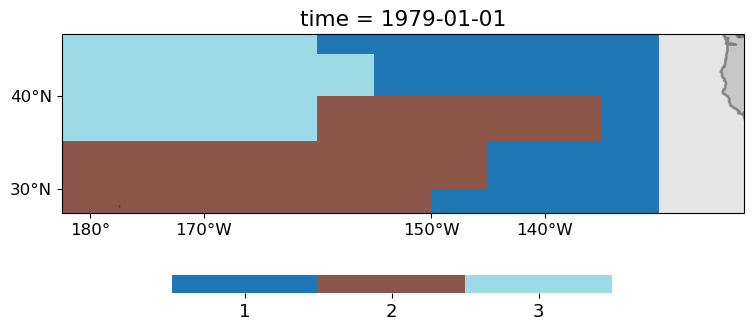

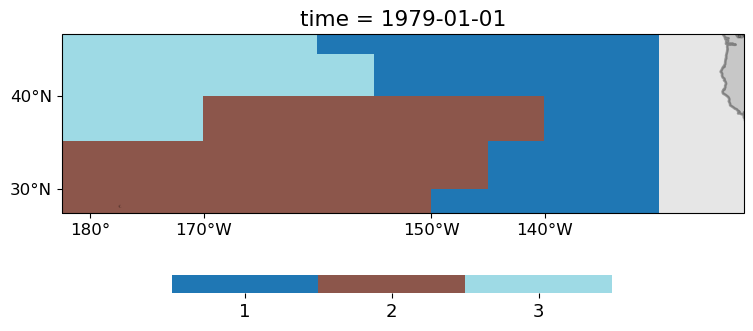

In [5]:
var_filename = rg.list_precur_pp[0][1]
mask = [145.0, 230.0, 20.0, 50.0]
for q in [85, 95]:
    xrclustered, results = cl.dendogram_clustering(var_filename, mask=mask, kwrgs_clust={'q':q, 'n_clusters':3})
    plot_maps.plot_labels(xrclustered)